In [480]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate,GridSearchCV
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
import seaborn as sns
%matplotlib inline

In [481]:
train=pd.read_csv('./train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [482]:
for col in ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
            'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
    train[col]=train[col].fillna(value='No')

In [483]:
train.shape

(1460, 81)

## Check Degenerate

In [484]:
tmp=train.astype(object)
deg_=[]
for col in list(tmp.columns):
    tol=tmp[col].value_counts()
    if (tol.iloc[0]//tol.iloc[1]>30) & (sum(tol.iloc[1:])/tmp.shape[0]<=0.1):
        print('degenerate column:',col,': with ratio',sum(tol.iloc[1:])/tmp.shape[0],'and',
             tol.iloc[0]//tol.iloc[1])
        deg_.append(col)

degenerate column: Street : with ratio 0.00410958904109589 and 242
degenerate column: Utilities : with ratio 0.0006849315068493151 and 1459
degenerate column: Condition2 : with ratio 0.010273972602739725 and 240
degenerate column: RoofMatl : with ratio 0.01780821917808219 and 130
degenerate column: Heating : with ratio 0.021917808219178082 and 79
degenerate column: LowQualFinSF : with ratio 0.01780821917808219 and 478
degenerate column: Functional : with ratio 0.0684931506849315 and 40
degenerate column: 3SsnPorch : with ratio 0.01643835616438356 and 478
degenerate column: ScreenPorch : with ratio 0.07945205479452055 and 224
degenerate column: PoolArea : with ratio 0.004794520547945206 and 1453
degenerate column: PoolQC : with ratio 0.004794520547945206 and 484
degenerate column: MiscVal : with ratio 0.03561643835616438 and 128


In [485]:
train=train.drop(deg_,axis=1)

In [486]:
train.shape

(1460, 69)

In [487]:
train_y=train['SalePrice']
train=train.drop('SalePrice',axis=1)

In [488]:
train_y=np.log(train_y)

(array([ 11.,  38.,  99., 232., 273., 218., 176., 104.,  93.,  58.,  42.,
         35.,  24.,  10.,  17.,   8.,   7.,   4.,   2.,   1.,   1.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   2.]),
 array([ 34900.        ,  58903.33333333,  82906.66666667, 106910.        ,
        130913.33333333, 154916.66666667, 178920.        , 202923.33333333,
        226926.66666667, 250930.        , 274933.33333333, 298936.66666667,
        322940.        , 346943.33333333, 370946.66666667, 394950.        ,
        418953.33333333, 442956.66666667, 466960.        , 490963.33333333,
        514966.66666667, 538970.        , 562973.33333333, 586976.66666667,
        610980.        , 634983.33333333, 658986.66666667, 682990.        ,
        706993.33333333, 730996.66666667, 755000.        ]),
 <a list of 30 Patch objects>)

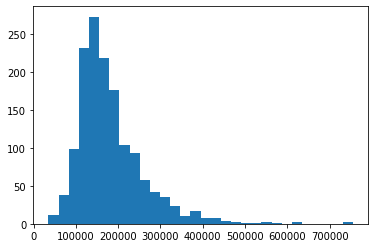

In [489]:
plt.hist(train_y,bins=30)

In [490]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,No,Reg,Lvl,Inside,Gtl,...,Y,0,61,0,No,No,2,2008,WD,Normal
1,2,20,RL,80.0,9600,No,Reg,Lvl,FR2,Gtl,...,Y,298,0,0,No,No,5,2007,WD,Normal
2,3,60,RL,68.0,11250,No,IR1,Lvl,Inside,Gtl,...,Y,0,42,0,No,No,9,2008,WD,Normal
3,4,70,RL,60.0,9550,No,IR1,Lvl,Corner,Gtl,...,Y,0,35,272,No,No,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,No,IR1,Lvl,FR2,Gtl,...,Y,192,84,0,No,No,12,2008,WD,Normal


## Check Null values

In [491]:
pd.DataFrame(train.isnull().sum()/train.shape[0]).reset_index().sort_values(0,ascending=False)

,index,0
3,LotFrontage,0.177397
52,GarageYrBlt,0.055479
21,MasVnrType,0.005479
22,MasVnrArea,0.005479
37,Electrical,0.000685
...,...,...
30,BsmtFinSF1,0.000000
31,BsmtFinType2,0.000000
32,BsmtFinSF2,0.000000
33,BsmtUnfSF,0.000000


## Check Distribution

([], <a list of 0 Text xticklabel objects>)

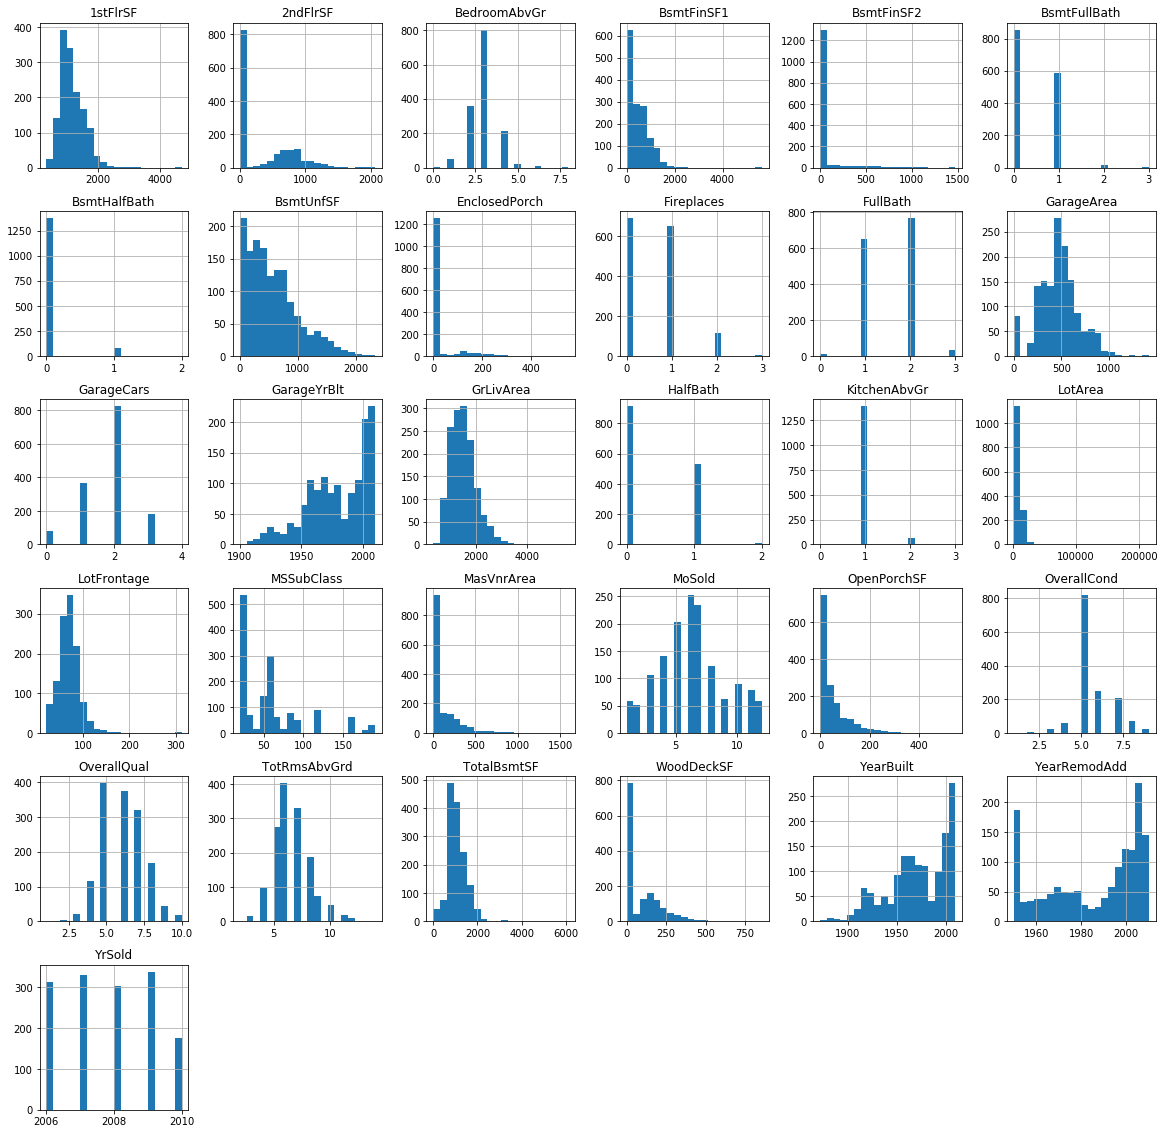

In [492]:
train.drop('Id',axis=1).hist(bins=20,figsize=(20,20))
plt.yticks([])
plt.xticks([])

In [493]:
num_=[]
for col in list(train.columns)[1:]:
    if np.dtype(train[col])!=object:
        num_.append(col)

train_num=train[num_]
train_obj=train.drop(num_,axis=1)

train_num=pd.DataFrame(power_transform(train_num.values,method='yeo-johnson'),columns=train_num.columns)
std=StandardScaler()
train_num=pd.DataFrame(std.fit_transform(train_num.values),columns=train_num.columns)

/Users/zhangdi/ACT4311/act/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


([], <a list of 0 Text xticklabel objects>)

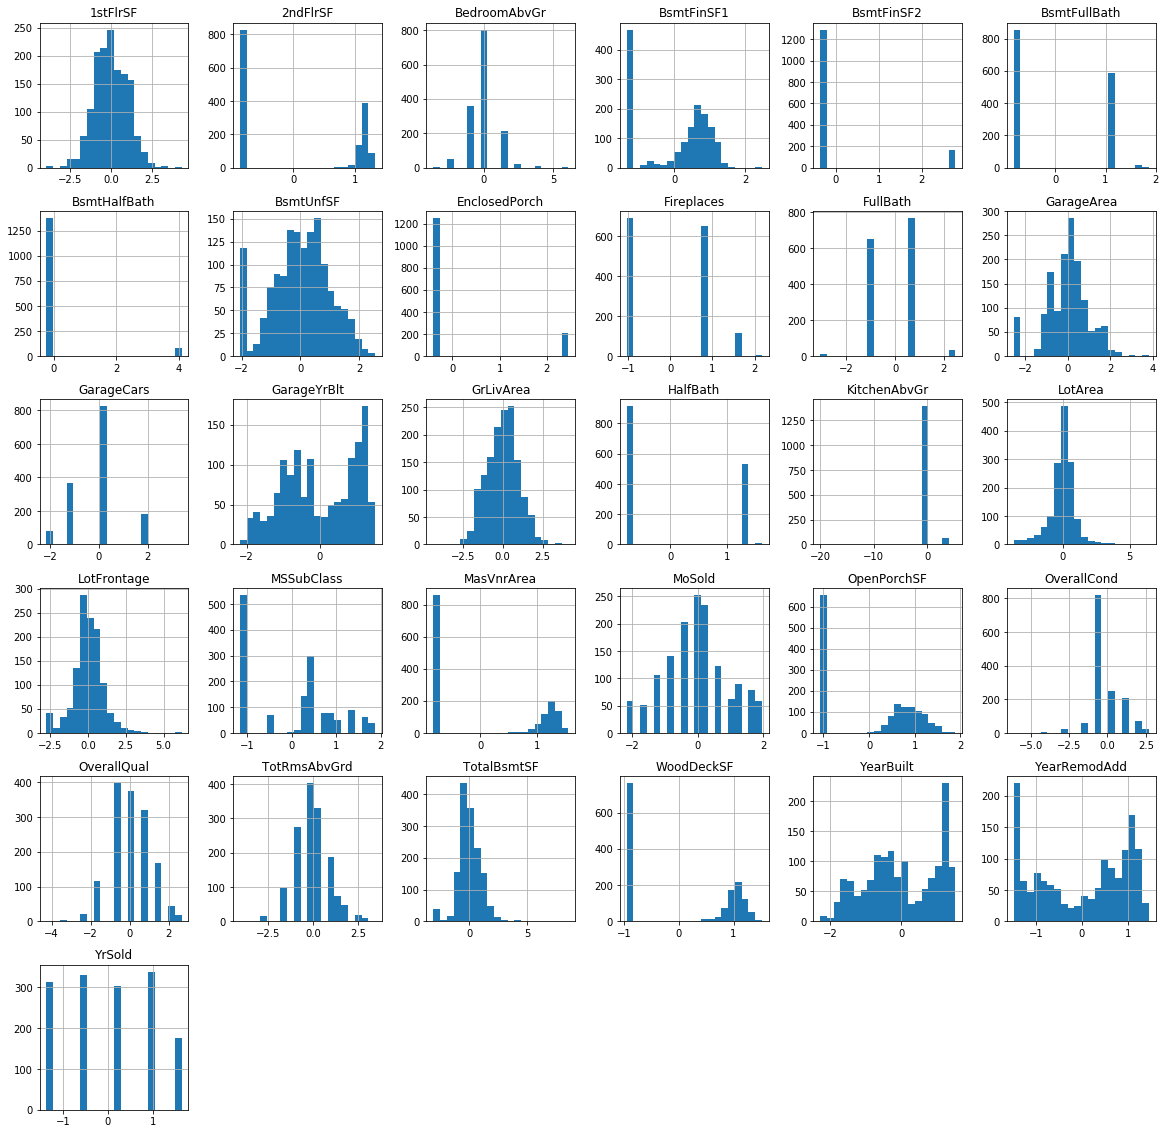

In [494]:
train_num.hist(bins=20,figsize=(20,20))
plt.yticks([])
plt.xticks([])

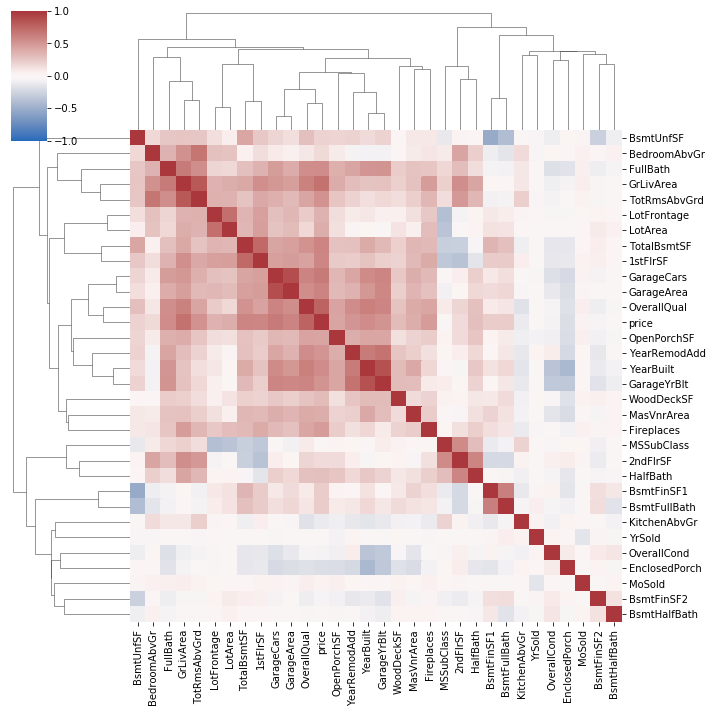

In [495]:
num_cor=train_num.copy()
num_cor['price']=train_y
sns.clustermap(num_cor.corr(),center=0,cmap='vlag',vmin=-1,vmax=1)

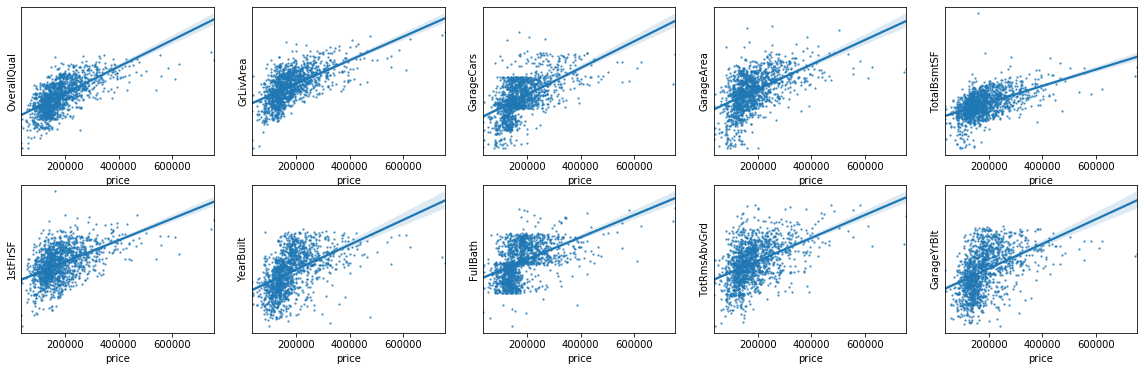

In [496]:
price_cor=list(pd.DataFrame(num_cor.corr()['price']).sort_values('price',ascending=False)[1:11].index)
plt.figure(figsize=(20,6))
i=1
for col in price_cor:
    plt.subplot(2,5,i)
    i+=1
    sns.regplot(x='price',y=col,data=num_cor,scatter_kws={'s':2,'alpha':0.6},y_jitter=True)
    plt.yticks(ticks=[])

In [497]:
num_cor[price_cor].corr()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,TotRmsAbvGrd,GarageYrBlt
OverallQual,1.000000,0.613478,0.602218,0.552158,0.528980,0.448602,0.624614,0.548881,0.432614,0.594769
GrLivArea,0.613478,1.000000,0.501675,0.468078,0.418893,0.544443,0.280024,0.650742,0.829971,0.283290
GarageCars,0.602218,0.501675,1.000000,0.885910,0.434136,0.453561,0.568139,0.473217,0.379208,0.601297
GarageArea,0.552158,0.468078,0.885910,1.000000,0.456263,0.474162,0.502277,0.397187,0.330784,0.582442
TotalBsmtSF,0.528980,0.418893,0.434136,0.456263,1.000000,0.742460,0.399910,0.301549,0.273705,0.331711
1stFlrSF,0.448602,0.544443,0.453561,0.474162,0.742460,1.000000,0.279781,0.364242,0.412576,0.219676
YearBuilt,0.624614,0.280024,0.568139,0.502277,0.399910,0.279781,1.000000,0.513362,0.146349,0.871701
FullBath,0.548881,0.650742,0.473217,0.397187,0.301549,0.364242,0.513362,1.000000,0.553577,0.519329
TotRmsAbvGrd,0.432614,0.829971,0.379208,0.330784,0.273705,0.412576,0.146349,0.553577,1.000000,0.176175
GarageYrBlt,0.594769,0.283290,0.601297,0.582442,0.331711,0.219676,0.871701,0.519329,0.176175,1.000000


In [498]:
pca=PCA()
pca.fit(train_num.dropna(axis=0))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [499]:
pca.explained_variance_ratio_

array([0.24429676, 0.11000654, 0.08960127, 0.07013993, 0.04227271,
       0.04037886, 0.0367359 , 0.03632415, 0.03267004, 0.02967082,
       0.02826591, 0.02680243, 0.02564148, 0.02387855, 0.02197666,
       0.01993541, 0.01859417, 0.01483098, 0.01349574, 0.01214376,
       0.01019832, 0.00877987, 0.00807086, 0.0078913 , 0.00725677,
       0.00599741, 0.00470398, 0.00335324, 0.0029172 , 0.00245636,
       0.0007126 ])

## Encoding

In [500]:
train_obj=train_obj.drop('Id',axis=1)

In [501]:
train_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Alley          1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   LotConfig      1460 non-null   object
 5   LandSlope      1460 non-null   object
 6   Neighborhood   1460 non-null   object
 7   Condition1     1460 non-null   object
 8   BldgType       1460 non-null   object
 9   HouseStyle     1460 non-null   object
 10  RoofStyle      1460 non-null   object
 11  Exterior1st    1460 non-null   object
 12  Exterior2nd    1460 non-null   object
 13  MasVnrType     1452 non-null   object
 14  ExterQual      1460 non-null   object
 15  ExterCond      1460 non-null   object
 16  Foundation     1460 non-null   object
 17  BsmtQual       1460 non-null   object
 18  BsmtCond       1460 non-null

## concat all

In [502]:
imp=SimpleImputer(strategy='median')
train_num=pd.DataFrame(imp.fit_transform(train_num),columns=train_num.columns)
train_num=pd.DataFrame(std.fit_transform(train_num),columns=train_num.columns)
pca.fit(train_num)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [503]:
sum(pca.explained_variance_ratio_[:20])

0.9321704883467314

In [504]:
pca=PCA(n_components=20)
train_num=pca.fit_transform(train_num)

In [505]:
train_num.shape

(1460, 20)

Text(0.5, 0, 'PC2')

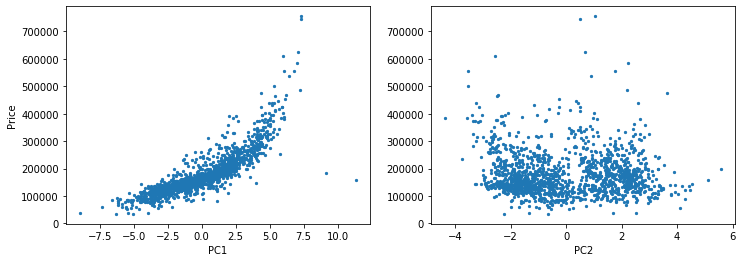

In [506]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(train_num[:,0],train_y,s=5)
plt.xlabel('PC1')
plt.ylabel('Price')
plt.subplot(122)
plt.scatter(train_num[:,1],train_y,s=5)
plt.xlabel('PC2')

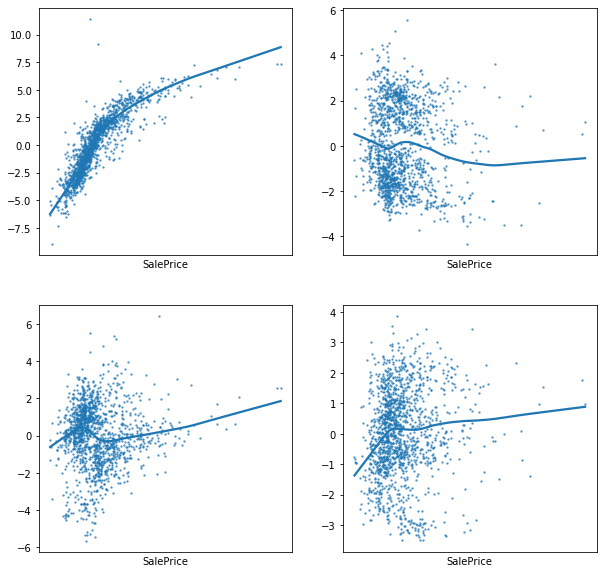

In [507]:
plt.figure(figsize=(10,10))
for i in range(1,5):
    plt.subplot(2,2,i)
    sns.regplot(x=train_y,y=train_num[:,(i-1)],scatter_kws={'s':2,'alpha':0.6},lowess=True)
    plt.xticks(ticks=[])

In [508]:
train_obj['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

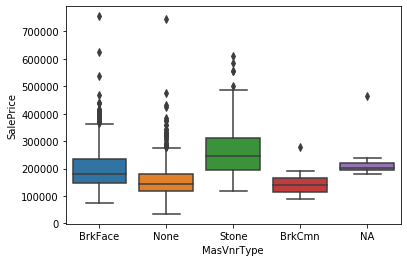

In [509]:
sns.boxplot(x=train_obj['MasVnrType'].fillna('NA'),y=train_y)

In [510]:
train_obj.MasVnrType=train_obj.MasVnrType.fillna('Stone')

In [511]:
train_obj['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

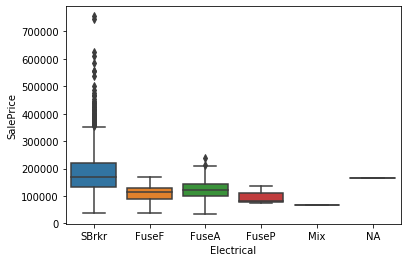

In [512]:
sns.boxplot(x=train_obj['Electrical'].fillna('NA'),y=train_y)

In [513]:
train_obj.Electrical=train_obj.Electrical.fillna('SBrkr')

In [514]:
len(list(train_obj.columns))

36

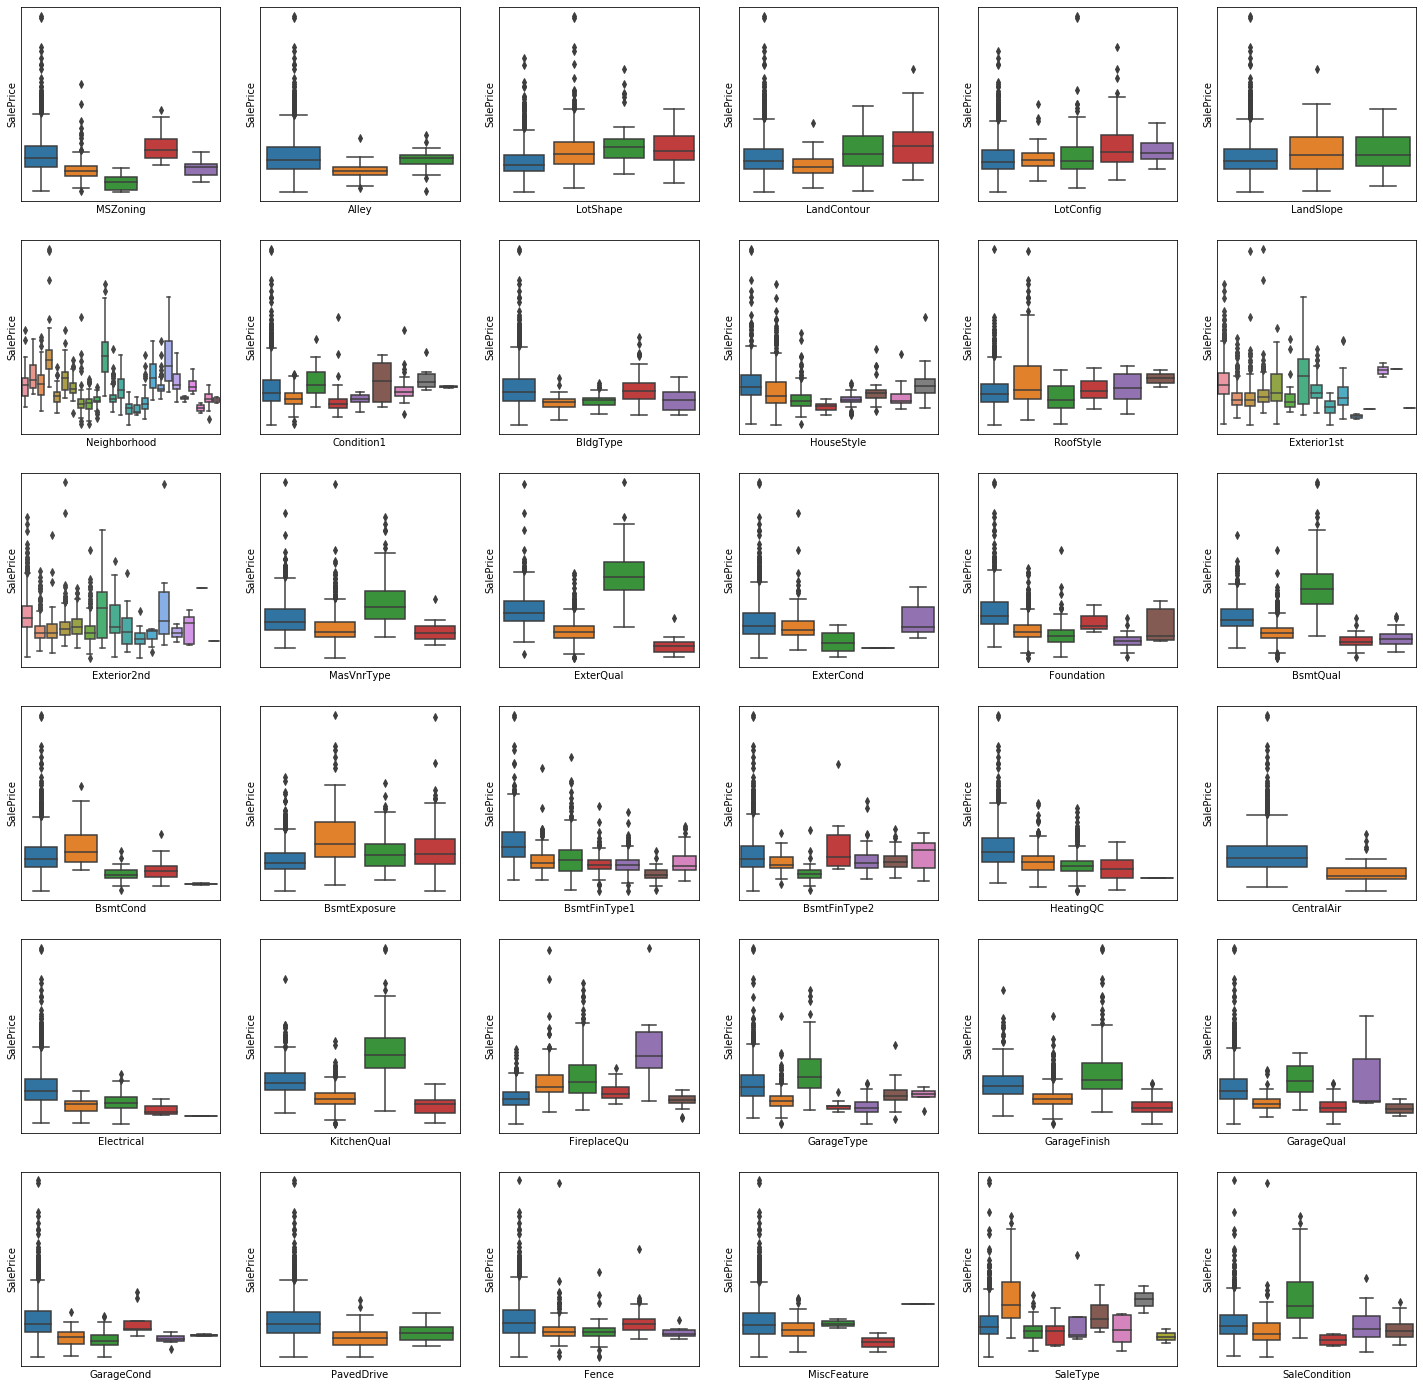

In [515]:
i=1
plt.figure(figsize=(25,25))
for col in list(train_obj.columns):
    plt.subplot(6,6,i)
    i+=1
    sns.boxplot(x=train_obj[col],y=train_y)
    plt.yticks(ticks=[])
    plt.xticks(ticks=[])

In [516]:
onehot=OneHotEncoder()
onehot.fit(train_obj)
obj_=list(train_obj.columns)

In [517]:
train_obj=pd.DataFrame(onehot.transform(train_obj).toarray(),columns=onehot.get_feature_names(obj_))

In [518]:
train_obj.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_No,Alley_Pave,LotShape_IR1,LotShape_IR2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [519]:
train_num=pd.DataFrame(train_num,columns=list('PC'+str(i) for i in range(20)))    
train_num.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,1.812463,0.791584,-1.826297,1.747888,-0.927593,-1.407996,-0.316144,0.962589,0.620843,0.290313,-1.222967,1.572849,-0.251788,0.626689,0.626543,0.107293,-0.383363,-0.190679,-0.029932,0.008958
1,-0.184210,-1.353747,1.503878,0.243120,2.494140,1.658178,2.732779,0.649250,0.691280,-0.365564,-0.875266,-0.178545,1.823891,1.190131,-0.702551,-0.130284,0.914187,0.114118,-0.392411,-0.619957
2,2.219282,0.608796,-1.324162,1.309658,-0.065877,-0.015431,-1.256441,0.292731,-0.077379,0.321010,-0.805662,-0.298194,-1.129000,0.240183,-0.184317,0.526464,-0.112862,-0.636019,-0.074719,0.497894
3,0.041755,0.953266,0.652618,0.619886,-0.437083,-0.783131,-1.891192,-1.446513,0.544626,-2.650899,-0.239215,1.575721,0.959842,0.944704,-0.313911,-0.234962,0.144378,1.105928,-0.098074,1.527522
4,4.658445,0.937032,-0.065022,1.610205,-0.036358,0.632502,-0.869558,0.375080,-0.825234,0.012488,-0.236685,-1.386211,-0.856539,0.379707,0.764466,-0.451474,-0.269651,0.335293,-0.073390,0.700472


In [520]:
train_df=pd.concat([train_num,train_obj],axis=1)
train_df.shape

(1460, 248)

## Model

In [539]:
pls=PLSRegression()
best_m=GridSearchCV(pls,param_grid={'n_components':[2,5,10,30,40,50]},
                   cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
best_m.fit(train_df,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_components': [2, 5, 10, 30, 40, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [540]:
best_m.best_score_

-33261.125866564325

In [209]:
svr=SVR(kernel='poly',degree=2)
best_m=GridSearchCV(svr,param_grid={'gamma':[1,2],'C':[0.0001,0.001,0.01]},
                   cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
best_m.fit(train_df,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01], 'gamma': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [210]:
best_m.best_score_

-0.13130451075032548

In [211]:
best_m.best_params_

{'C': 0.0001, 'gamma': 1}

In [353]:
clf = LGBMRegressor(random_state = 50, n_jobs = -1)
best_clf = GridSearchCV(clf,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1,
                        param_grid={'n_estimators': [50,100,200,500],
                        'reg_lambda':[0.001,0.01,0.1,1,10]})
best_clf.fit(train_df,train_y)
print("Select best LGB model with n_estimators = {} and reg_lambda={} with best_score={}".format(
    best_clf.best_params_['n_estimators'],best_clf.best_params_['reg_lambda'],
    best_clf.best_score_))

Select best LGB model with n_estimators = 100 and reg_lambda=1 with best_score=-0.13316991049910112


In [355]:
clf = XGBRegressor(random_state = 50, n_jobs = -1)
best_clf = GridSearchCV(clf,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1,
                        param_grid={'n_estimators': [50,100,200,500],
                        'reg_lambda':[0.001,0.01,0.1,1,10]})
best_clf.fit(train_df,train_y)
print("Select best xgboost model with n_estimators = {} and reg_lambda={} with best_score={}".format(
    best_clf.best_params_['n_estimators'],best_clf.best_params_['reg_lambda'],
    best_clf.best_score_))

Select best xgboost model with n_estimators = 100 and reg_lambda=1 with best_score=-0.1353386088968291


## Test

In [521]:
test=pd.read_csv('./test.csv')
test=test.iloc[:,1:]
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [522]:
for col in ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
            'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
    test[col]=test[col].fillna(value='No')
test=test.drop(deg_,axis=1)
pd.DataFrame(test.isnull().sum()/test.shape[0]).reset_index().sort_values(0,ascending=False)

,index,0
2,LotFrontage,0.155586
51,GarageYrBlt,0.053461
20,MasVnrType,0.010966
21,MasVnrArea,0.010281
1,MSZoning,0.002742
...,...,...
28,BsmtFinType1,0.000000
30,BsmtFinType2,0.000000
34,HeatingQC,0.000000
35,CentralAir,0.000000


In [523]:
num_=[]
for col in list(test.columns)[1:]:
    if np.dtype(test[col])!=object:
        num_.append(col)
num_.append('MSSubClass')
test_num=test[num_]
test_obj=test.drop(num_,axis=1)

test_num['MSSubClass']=test_num['MSSubClass'].astype(int)
test_num=pd.DataFrame(power_transform(test_num.values,method='yeo-johnson'),columns=test_num.columns)
test_num=pd.DataFrame(std.fit_transform(test_num.values),columns=test_num.columns)

/Users/zhangdi/ACT4311/act/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/zhangdi/ACT4311/act/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [524]:
test_num=pd.DataFrame(imp.transform(test_num),columns=test_num.columns)
pca=PCA(n_components=20)
test_num=pca.fit_transform(test_num)

In [525]:
pd.DataFrame(test_obj.isnull().sum()/test_obj.shape[0]).reset_index().sort_values(0,ascending=False).iloc[:8,:]

,index,0
13,MasVnrType,0.010966
0,MSZoning,0.002742
34,SaleType,0.000685
25,KitchenQual,0.000685
12,Exterior2nd,0.000685
11,Exterior1st,0.000685
26,FireplaceQu,0.000000
22,HeatingQC,0.000000


In [526]:
col_obj=train[['MasVnrType','MSZoning','KitchenQual','SaleType','Exterior2nd','Exterior1st']]

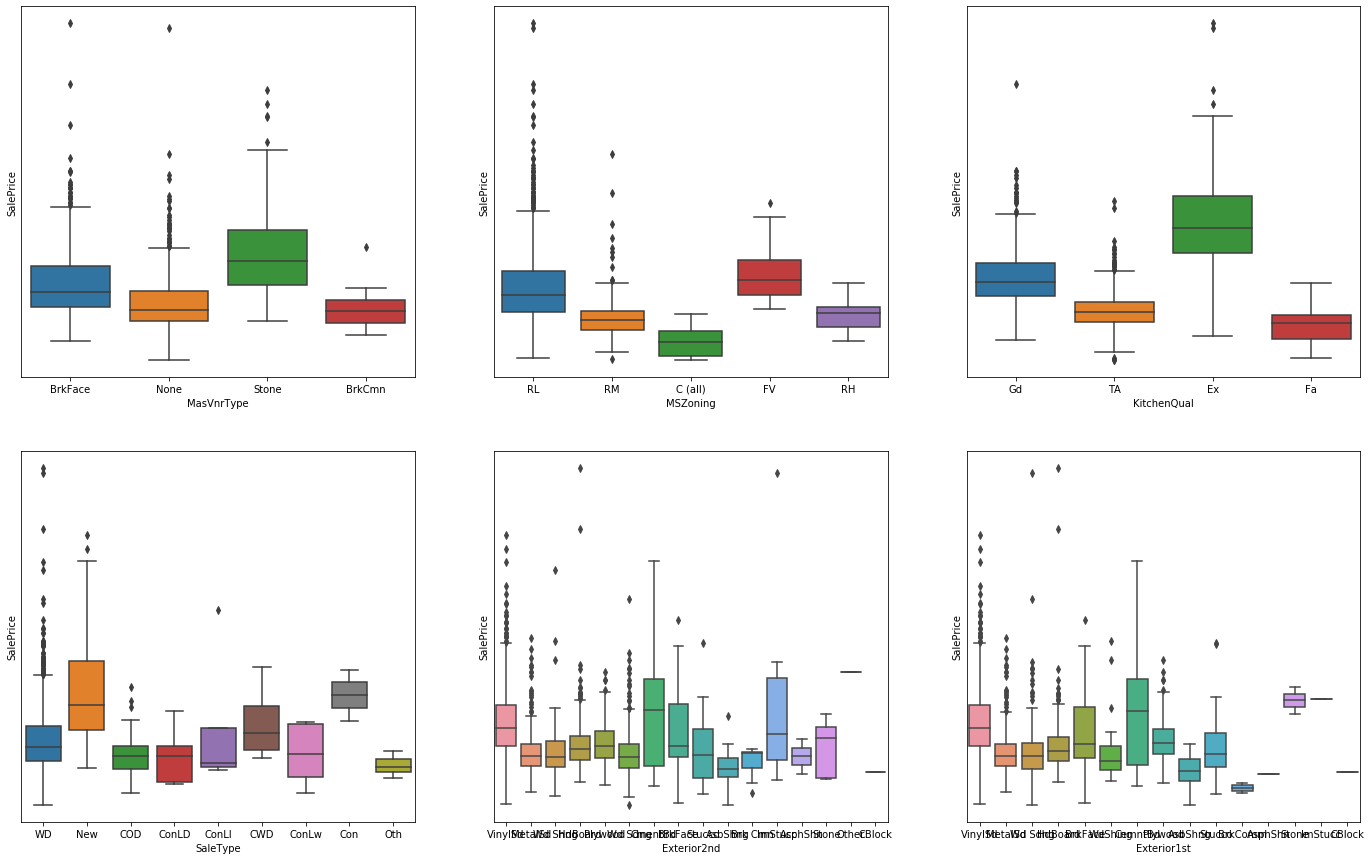

In [527]:
i=1
plt.figure(figsize=(24,15))
for col in list(col_obj.columns):
    plt.subplot(2,3,i)
    i+=1
    sns.boxplot(x=col_obj[col],y=train_y)
    plt.yticks(ticks=[])

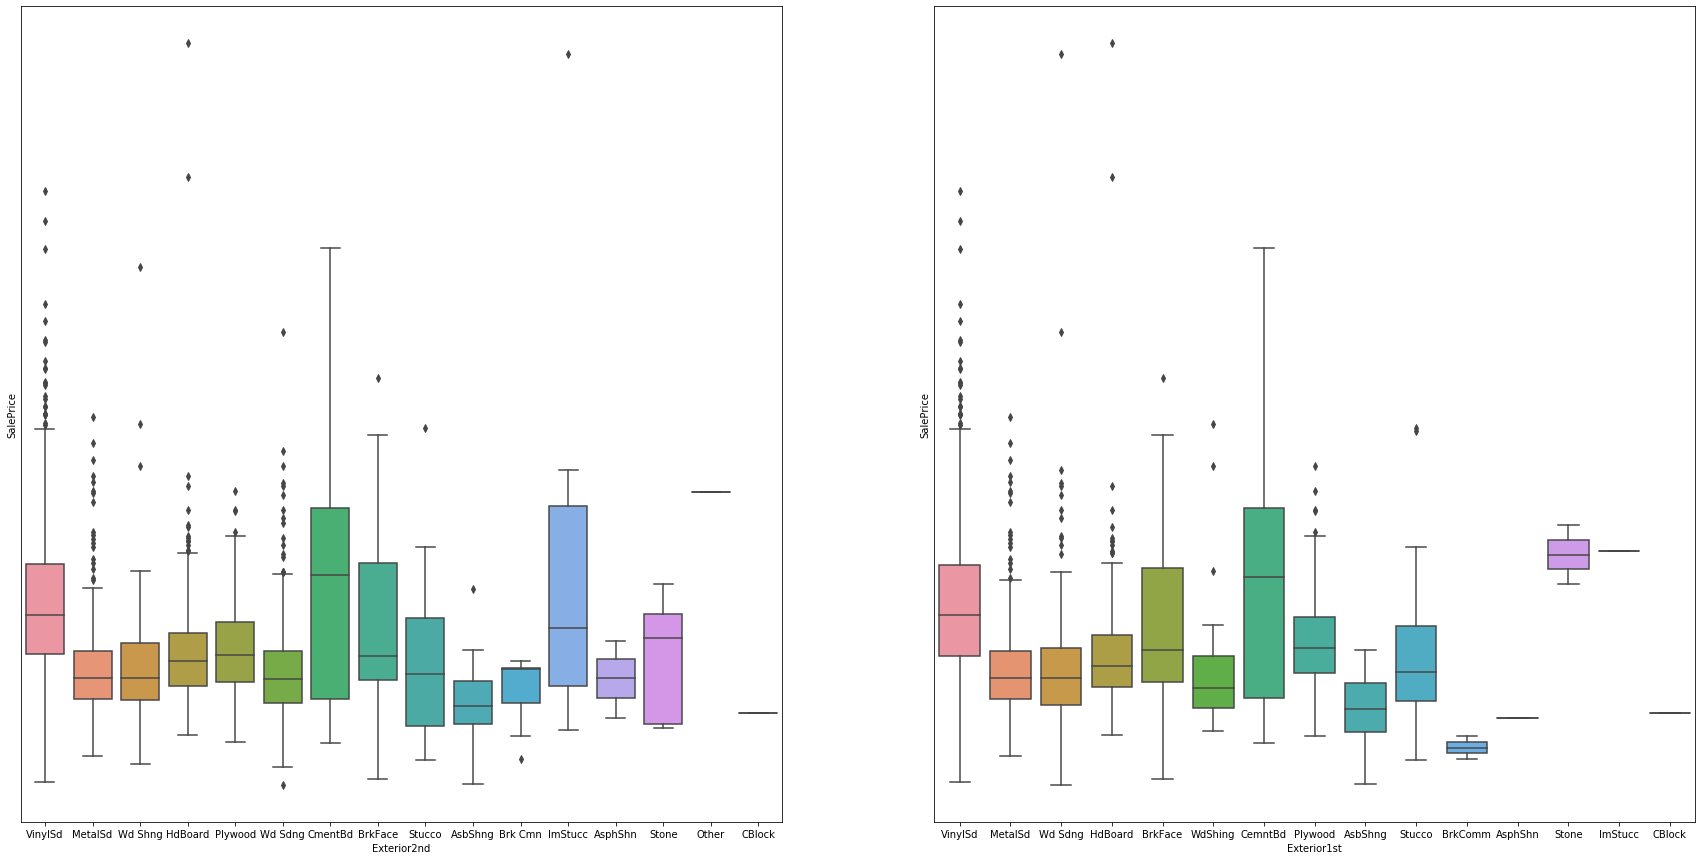

In [528]:
i=1
plt.figure(figsize=(30,15))
for col in list(col_obj.columns[-2:]):
    plt.subplot(1,2,i)
    i+=1
    sns.boxplot(x=col_obj[col],y=train_y)
    plt.yticks(ticks=[])

In [529]:
test_obj['MasVnrType']=test_obj['MasVnrType'].fillna(value='Stone')
test_obj['MSZoning']=test_obj['MSZoning'].fillna(value='FV')
test_obj['KitchenQual']=test_obj['KitchenQual'].fillna(value='Fa')
test_obj['SaleType']=test_obj['SaleType'].fillna(value='New')
test_obj['Exterior2nd']=test_obj['Exterior2nd'].fillna(value='ImStucc')
test_obj['Exterior1st']=test_obj['Exterior1st'].fillna(value='Stucco')

In [530]:
pd.DataFrame(test_obj.isnull().sum()/test_obj.shape[0]).reset_index().sort_values(0,ascending=False).iloc[:8,:]

,index,0
0,MSZoning,0.0
1,Alley,0.0
20,BsmtFinType1,0.0
21,BsmtFinType2,0.0
22,HeatingQC,0.0
23,CentralAir,0.0
24,Electrical,0.0
25,KitchenQual,0.0


In [531]:
test_obj=onehot.transform(test_obj)

In [532]:
test_obj=test_obj.toarray()

In [533]:
test=np.concatenate([test_num,test_obj],axis=1)

In [534]:
test.shape

(1459, 248)

In [535]:
svr=SVR(kernel='poly',degree=2,C=0.0001,gamma=1)
svr.fit(train_df,train_y)

SVR(C=0.0001, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [536]:
test_pred=svr.predict(test)

In [537]:
test_pred=np.exp(test_pred)

In [538]:
pd.DataFrame(test_pred).to_csv('./pred.csv',index=False)